In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import fnmatch
import numpy as np
import os
from surgeNN import io, preprocessing
from surgeNN.denseLoss import get_denseloss_weights
#script to plot observation weights as function of alpha

2025-07-08 07:25:01.917050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-08 07:25:01.985161: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Configure the script:

In [2]:
tg = 'den_helder-denhdr-nld-rws.csv'
temp_freq = 3 # [hours] temporal frequency to use

Load in & preprocess data:

In [5]:
predictors = io.Predictor('gs://leap-persistent/timh37/era5_predictors/3hourly')
predictors.open_dataset(tg,['u10','v10','msl','w'],20)
predictors.trim_years(1979,2017)

predictand = io.Predictand('/home/jovyan/surgeNN/input/t_tide_3h_hourly_deseasoned_predictands')
predictand.open_dataset(tg)
predictand.trim_dates(predictors.data.time.isel(time=0).values,predictors.data.time.isel(time=-1).values)
predictand.deseasonalize()
predictand.resample_fillna(str(temp_freq)+'h')

model_input = preprocessing.Input(predictors,predictand)
model_input.stack_predictor_coords()
model_input.split_stratified([.6,.2,.2],9,7,0,'99pct')
y_train_mean,y_train_sd = model_input.standardize()

Text(0.5, 1.0, 'Den Helder (NL)')

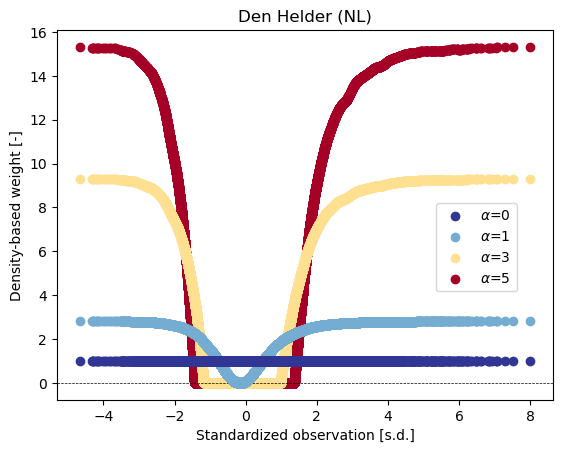

In [6]:
w_trains = []
w_vals = []

alpha_cmap = plt.get_cmap('RdYlBu_r', 6) #alpha colormap

plt.figure()

for alpha in np.array([0,1,3,5]):
    w_train,w_val = [get_denseloss_weights(k, alpha = alpha ) for k in [model_input.y_train,model_input.y_val]] #generate DenseLoss weights for train & val splits   
    w_trains.append(w_train)
    w_vals.append(w_val)
    
    plt.scatter(model_input.y_train,w_train,label='$\\alpha$='+str(alpha),zorder=5-alpha,facecolor=alpha_cmap(alpha))
plt.axhline(y=0,color='black',linestyle='dashed',linewidth=.5)
plt.xlabel('Standardized observation [s.d.]')
plt.ylabel('Density-based weight [-]')
plt.legend(bbox_to_anchor=(.75, .55), loc='upper left',ncol=1)
plt.title('Den Helder (NL)')

#plt.savefig('nhess_figures/figD1_weights_alpha.jpg', bbox_inches='tight',dpi=300,format='jpg')